


## What kind of problem to solve?

Music Personalize Recommendation, here because of the target column is binary, we take this as a classification problem, in a nutshell, this is a binary classification.

In [2]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time, html
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns
import numba

from sklearn import preprocessing
from collections import defaultdict, Counter, OrderedDict
from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer.utils import utils, utils_nb
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(42)

## Preview
<br/>

### train.csv
Column | Description
--:--  | --:-- 
msno | user id
song_id | song id
source_system_tab | the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name | name of the layout a user sees.
source_type | an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target | this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
<br/>

## songs.csv
Column | Description
--:--  | --:-- 
song_id | 
song_length | in ms
genre_ids | genre category. Some songs have multiple genres and they are separated by
artist_name | 
composer | 
lyricist | 
language |
<br/>

## members.csv
Column | Description
--:--  | --:-- 
msno | 
city | 
bd | age. Note: this column has outlier values, please use your judgement.
gender | 
registered_via | registration method
registration_init_time | format %Y%m%d
expiration_date | format %Y%m%d

## song_extra_info.csv
Column | Description
--:--  | --:-- 
song_id | 
song name | the name of the song.
isrc | International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [2]:
utils.preview('./data/train.csv')

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
utils.preview('./data/test.csv')

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [4]:
utils.preview('./data/members.csv')

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
utils.preview('./data/songs.csv')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
utils.preview('./data/song_extra_info.csv')

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


<br/>
<br/>
<br/>
## Data Clean, Data Type Fix

1. Drop `name` in `song_extra_info`

In [8]:
%%time
tr = pd.read_csv('./data/train.csv')
members = pd.read_csv('./data/members.csv')
songs = pd.read_csv('./data/songs.csv')\
          .merge(pd.read_csv('./data/song_extra_info.csv'), how='left', on='song_id')\
          .drop('name', 1)

Wall time: 30.3 s


### Interaction table

In [9]:
%%time
# source_system_tab source_screen_name source_type
tr['source_system_tab'] = tr.source_system_tab.fillna('')
tr['source_screen_name'] = tr.source_screen_name.fillna('')
tr['source_type'] = tr.source_type.fillna('')

Wall time: 1.15 s


### members

In [10]:
%%time
members['gender'] = members.gender.fillna('')

date_fmt = '%Y%m%d'
members['registration_init_time'] = pd.to_datetime(members.registration_init_time, format=date_fmt).map(lambda e: e.timestamp() / 86400)
members['expiration_date'] = pd.to_datetime(members.expiration_date, format=date_fmt).map(lambda e: e.timestamp() / 86400)

members['registered_via'] = members.registered_via.astype(str)
members['city'] = members.city.astype(str)

Wall time: 615 ms


### songs

In [11]:
%%time
def str2tuple(series):
    return series.fillna('')\
                 .map(html.unescape)\
                 .str.replace('[^.\w\|]+', ' ')\
                 .str.replace('^[\s\|]+|[\s\|]+$', '')\
                 .str.split('\s*\|+\s*')\
                 .map(lambda ary: tuple(sorted(ary)))

songs['genre_ids'] = str2tuple(songs['genre_ids'])
songs['artist_name'] = str2tuple(songs['artist_name'])
songs['composer'] = str2tuple(songs['composer'])
songs['lyricist'] = str2tuple(songs['lyricist'])
songs['language'] = songs.language.fillna(0).map(int, na_action='ignore').map(str)

Wall time: 49.3 s


### Filter Train Data and Split Train Valid

In [12]:
msno_count = tr.groupby('msno').size()
pos_count = tr.query('target == 1').groupby('msno').size()
print(msno_count.describe(), '\n')
print(pos_count.describe())

count    30755.000000
mean       239.877028
std        314.130788
min          1.000000
25%         27.000000
50%        128.000000
75%        340.000000
max       5819.000000
dtype: float64 

count    27113.000000
mean       137.006454
std        176.338947
min          1.000000
25%         17.000000
50%         76.000000
75%        192.000000
max       3288.000000
dtype: float64


In [13]:
%%time
msno_describe = msno_count.describe()
per25, per75 = int(msno_describe['25%']), int(msno_describe['75%'])

valid_size = 0.2
def filter_fn(pipe):
    # At least 25 percentile
    if len(pipe) >= per25:
        # At most 75 percentile of latest data
        pipe = pipe[-per75:]
        len_ = len(pipe)
        is_train = np.zeros(len_)
        tr_size = int(len_ * (1 - valid_size))
        is_train[:tr_size] = 1.
        pipe['is_train'] = is_train
        return pipe

tr = tr.groupby('msno', as_index=False, sort=False).apply(filter_fn)
vl = tr.query('is_train == 0').drop('is_train', 1).reset_index(drop=True)
tr = tr.query('is_train == 1').drop('is_train', 1).reset_index(drop=True)

Wall time: 20.7 s


In [14]:
%%time
# Because of performance of pandas.to_csv too slow, use this will be greate
# import csv
# def to_csv(path, df, header=True):
#     with open(path, 'w', newline='') as fp:
#         w = csv.writer(fp)
#         if header:
#             w.writerows(df.columns[None, :])
#         w.writerows(df.values)

# Write to pickle for speed
tr.to_hdf('./data/processed/cleaned/tr.h', key='df')
vl.to_hdf('./data/processed/cleaned/vl.h', key='df')

Wall time: 6.59 s


In [15]:
members.to_hdf('./data/processed/cleaned/member.h', key='df')
songs.to_hdf('./data/processed/cleaned/songs.h', key='df')

d:\python\anaconda3\envs\py3_6\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['song_id', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'isrc']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


<br/>
<br/>
<br/>
## Phase 1: Prepare,  Add Columns, Feature Engineering

In [35]:
%%time
members = pd.read_hdf('./data/processed/cleaned/member.h', key='df')
songs = pd.read_hdf('./data/processed/cleaned/songs.h', key='df')
tr = pd.read_hdf('./data/processed/cleaned/tr.h', key='df')
vl = pd.read_hdf('./data/processed/cleaned/vl.h', key='df')
data = tr.merge(songs, how='left', on='song_id')

Wall time: 18.4 s


### members extra columns

In [36]:
%%time
msno_extra_cols = [
    'msno_age_catg', 'msno_age_num', 'msno_tenure',
    'msno_artist_name_hist', 'msno_artist_name_count', 'msno_artist_name_mean',
    'msno_composer_hist', 'msno_composer_count', 'msno_composer_mean',
    'msno_genre_ids_hist', 'msno_genre_ids_count', 'msno_genre_ids_mean',
    'msno_language_hist', 'msno_language_count', 'msno_language_mean',
    'msno_lyricist_hist', 'msno_lyricist_count', 'msno_lyricist_mean',
    'msno_pos_query_hist', 'msno_pos_query_count', 
    'msno_neg_query_hist', 'msno_neg_query_count', 
    'msno_source_screen_name_hist', 'msno_source_screen_name_count',
    'msno_source_system_tab_hist','msno_source_system_tab_count', 
    'msno_source_type_hist', 'msno_source_type_count']

bd = members.bd.copy()
bins = np.array([6, 10, 20, 30, 40, 60, 80])
age_map = {0: '', 1: '6-10', 2: '10-20', 3: '20-30', 4: '30-40', 5: '40-60', 6: '60-80', 7: ''}
members['msno_age_catg'] = pd.Series(np.digitize(bd, bins)).map(age_map)

reasonable_range = (6 <= bd) & (bd <= 80)
median = bd[reasonable_range].describe()['50%']
bd[~reasonable_range] = median
members['msno_age_num'] = bd
members = members.drop('bd', 1)
# Tenure: the customer life time
members['msno_tenure'] = members.expiration_date - members.registration_init_time

Wall time: 31.9 ms


In [37]:
%%time
msno_extra = {}
base_msno = data.msno.unique()
def msno_statis(data, col, to_calc, is_multi=False):
    label_name = f'msno_{col}_hist'
    calc_names = [f'msno_{col}_{calc}' for calc in to_calc]
    if is_multi:
        msno, multi, target = utils_nb.flat(data, col)
        data = pd.DataFrame({'msno': msno, col: multi, 'target': target})
        
    series = data.groupby(['msno', col]).target.agg(to_calc).reset_index()
    def map_fn(pipe):
        ret = {label_name: tuple(sorted(pipe[col]))}
        ret.update({f'msno_{col}_{calc}': tuple(sorted(pipe[calc])) for calc in to_calc})
        return ret
    
    series = series.groupby('msno').apply(map_fn).reindex(base_msno)
    na_conds = series.isna()
    na_value = {label_name: ('',)}
    na_value.update({c: (0.,) for c in calc_names})
    series[na_conds] = [na_value] * len(na_conds)
    return extract_col(series)

def extract_col(series):
    ret = {k: [] for k in series.values[0].keys()}
    series.map(lambda dict_: [ret[k].append(v) for k, v in dict_.items()])
    return ret

# positive + negative songs query
for key in ('pos', 'neg'):
    name = f'{key}_query'
    lable_name, w_name = f'msno_{name}_hist', f'msno_{name}_count'
    query = data.query(f"target == {1 if key == 'pos' else 0}")\
                .groupby('msno')\
                .apply(lambda e: {lable_name: tuple(e.song_id), w_name: (1.,) * len(e)})\
                .reindex(base_msno)
    na_conds = query.isna()
    query[na_conds] = [{lable_name: ('',), w_name: (0.,)}] * len(na_conds)
    msno_extra.update(extract_col(query))
    
# Freq distribution of each member interaction with context
for col in ('source_system_tab', 'source_screen_name', 'source_type'):
    msno_extra.update( msno_statis(data, col, ['count']) )

# Preference of each member, calculate freq and mean
msno_extra.update( msno_statis(data, 'language', ['count', 'mean']))
for col in ('artist_name', 'composer', 'genre_ids', 'composer', 'lyricist'):
    msno_extra.update(msno_statis(data, col, ['count', 'mean'], is_multi=True))

msno_extra = pd.DataFrame(msno_extra)
msno_extra['msno'] = base_msno
members = members.merge(msno_extra, how='left', on='msno')

# After merge, some members dosen't have any statistic values make the null, so fill default values
for stats_feat in msno_extra_cols:
    if stats_feat in ('msno_age_catg', 'msno_age_num', 'msno_tenure'): continue

    na_conds = members[stats_feat].isna()
    if stats_feat.endswith('_hist'):
        na_value = ('',)
    elif stats_feat.endswith('_count') or stats_feat.endswith('_mean'):
        na_value = (0.,)
    members.loc[na_conds, stats_feat] = members[stats_feat][na_conds].map(lambda na: na_value)

Wall time: 2min 8s


In [38]:
%%time
members.to_hdf('./data/processed/prepared/member.h', key='df')

d:\python\anaconda3\envs\py3_6\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['msno', 'city', 'gender', 'registered_via', 'msno_age_catg', 'msno_artist_name_count', 'msno_artist_name_hist', 'msno_artist_name_mean', 'msno_composer_count', 'msno_composer_hist', 'msno_composer_mean', 'msno_genre_ids_count', 'msno_genre_ids_hist', 'msno_genre_ids_mean', 'msno_language_count', 'msno_language_hist', 'msno_language_mean', 'msno_lyricist_count', 'msno_lyricist_hist', 'msno_lyricist_mean', 'msno_neg_query_count', 'msno_neg_query_hist', 'msno_pos_query_count', 'msno_pos_query_hist', 'msno_source_screen_name_count', 'msno_source_screen_name_hist', 'msno_source_system_tab_count', 'msno_source_system_tab_hist', 'msno_source_type_count', 'msno_source_type_hist']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Wall time: 5.66 s


### songs extra columns

In [142]:
# songs = pd.read_hdf('./data/processed/cleaned/songs.h')
# tr = pd.read_hdf('./data/processed/cleaned/tr.h')

In [39]:
# members = pd.read_hdf('./data/processed/prepared/member.h')
data = tr.merge(members,  how='left', on='msno')

In [40]:
%%time
song_extra_cols = [
    'song_cc', 'song_xxx', 'song_yy', 'song_length', 'song_pplrty', 'song_clicks',
    'song_artist_name_len', 'song_composer_len', 'song_lyricist_len', 'song_genre_ids_len',
    'song_city_hist', 'song_city_count', 'song_city_mean',
    'song_gender_hist', 'song_gender_count', 'song_gender_mean',
    'song_msno_age_catg_hist', 'song_msno_age_catg_count', 'song_msno_age_catg_mean', 
    'song_registered_via_hist', 'song_registered_via_count',
    'song_source_screen_name_hist', 'song_source_screen_name_count', 
    'song_source_system_tab_hist', 'song_source_system_tab_count',  
    'song_source_type_hist', 'song_source_type_count'
]

# Decode isrc
songs['song_cc'] = songs.isrc.str.slice(0, 2).fillna('')
songs['song_xxx'] = songs.isrc.str.slice(2, 5).fillna('')

songs['song_yy'] = songs.isrc.str.slice(5, 7)\
                        .map(lambda e: 2000 + int(e) if int(e) < 18 else 1900 + int(e), na_action='ignore')
songs['song_yy'] = songs.song_yy.fillna(songs.song_yy.median())
songs['song_yy'] = songs.song_yy - 1900

songs['song_artist_name_len'] = songs.artist_name.map(len)
songs['song_composer_len'] = songs.composer.map(len)
songs['song_lyricist_len'] = songs.lyricist.map(len)
songs['song_genre_ids_len'] = songs.genre_ids.map(len)

songs.drop('isrc', 1, inplace=True)

Wall time: 12.1 s


In [41]:
%%time
def song_statis(data, col, to_calc, is_multi=False):
    s = datetime.now()
    label_name = f'song_{col}_hist'
    calc_names = [f'song_{col}_{calc}' for calc in to_calc]
    if is_multi:
        song, multi, target = utils_nb.flat(data, col)
        data = pd.DataFrame({'song': song, col: multi, 'target': target})
    series = data.groupby(['song_id', col]).target.agg(to_calc).reset_index()
    
    def map_fn(pipe):
        ret = {label_name: tuple(sorted(pipe[col]))}
        ret.update({f'song_{col}_{calc}': tuple(sorted(pipe[calc])) for calc in to_calc})
        return ret
    series = series.groupby('song_id').apply(map_fn).reindex(base_song)
    
    na_conds = series.isna()
    na_value = {label_name: ('',)}
    na_value.update({c: (0.,) for c in calc_names})
    series[na_conds] = [na_value] * len(na_conds)
    ret = extract_col(series)
    print(f'{col} {",".join(to_calc)} done, take {datetime.now() - s}')
    return ret

base_song = data.song_id.unique()
basic_stats = data.groupby('song_id').target.agg(['count', 'mean'])
basic_stats['song_clicks'] = basic_stats['count']
basic_stats['song_pplrty'] = basic_stats['mean']
basic_stats = basic_stats.drop(['count', 'mean'], 1).reset_index()
print(f'song_clicks done.')
print(f'song_pplrty done.')

songs_extra = {}
# Freq distribution of each song interaction with context
for col in ('source_system_tab', 'source_screen_name', 'source_type', 'registered_via'):
    songs_extra.update( song_statis(data, col, ['count']) )

# Preference of each song, calculate freq and mean
for col in ('city', 'gender', 'msno_age_catg'):
    songs_extra.update( song_statis(data, col, ['count', 'mean']) )
    
songs_extra = pd.DataFrame(songs_extra)
songs_extra['song_id'] = base_song
songs = songs.merge(songs_extra, how='left', on='song_id').merge(basic_stats, how='left', on='song_id')

# After merge, some members dosen't have any statistic values make the null, so fill default values
for stats_feat in song_extra_cols:
    if stats_feat in ('song_cc', 'song_xxx', 'song_yy', 'song_length',
            'song_artist_name_len', 'song_composer_len', 'song_lyricist_len', 'song_genre_ids_len'): 
        continue

    na_conds = songs[stats_feat].isna()
    if stats_feat.endswith('_hist'):
        songs.loc[na_conds, stats_feat] = songs[stats_feat][na_conds].map(lambda na: ('',))
    elif stats_feat.endswith('_count') or stats_feat.endswith('_mean'):
        songs.loc[na_conds, stats_feat] = songs[stats_feat][na_conds].map(lambda na: (0.,))
    elif stats_feat in ('song_pplrty', 'song_clicks'):
        songs[stats_feat] = songs[stats_feat].fillna(songs[stats_feat].median())

song_clicks done.
song_pplrty done.
source_system_tab count done, take 0:00:33.866416
source_screen_name count done, take 0:00:31.988885
source_type count done, take 0:00:32.088213
registered_via count done, take 0:00:32.093310
city count,mean done, take 0:00:46.725035
gender count,mean done, take 0:00:45.765584
msno_age_catg count,mean done, take 0:00:47.020640
Wall time: 4min 49s


In [43]:
%%time
songs.to_hdf('./data/processed/prepared/songs.h', key='df')

d:\python\anaconda3\envs\py3_6\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['song_id', 'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 'song_cc', 'song_xxx', 'song_city_count', 'song_city_hist', 'song_city_mean', 'song_gender_count', 'song_gender_hist', 'song_gender_mean', 'song_msno_age_catg_count', 'song_msno_age_catg_hist', 'song_msno_age_catg_mean', 'song_registered_via_count', 'song_registered_via_hist', 'song_source_screen_name_count', 'song_source_screen_name_hist', 'song_source_system_tab_count', 'song_source_system_tab_hist', 'song_source_type_count', 'song_source_type_hist']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Wall time: 24.1 s


In [46]:
# Write to hdf for speed
tr.to_hdf('./data/processed/prepared/tr.h', key='df')
vl.to_hdf('./data/processed/prepared/vl.h', key='df')

## Fit
1. 記住feature狀態, 這裡選擇fit merge過後的fat table, 照理說fit profile table就好(像songs, members), 
雖然fit fat table資料會虛增造成效能慢, 但是有時候會去計算feature出現的頻率, 有些超冷門類別就乾脆transform成0就好, 
這邊從profile資料就無法做到, 這也是選擇fit fat table的原因

### load latest persistent data

In [86]:
%%time
members = pd.read_hdf('./data/processed/prepared/member.h', key='df')
songs = pd.read_hdf('./data/processed/prepared/songs.h', key='df')
tr = pd.read_hdf('./data/processed/prepared/tr.h', key='df')
vl = pd.read_hdf('./data/processed/prepared/vl.h', key='df')
data = tr.merge(members, how='left', on='msno').merge(songs, how='left', on='song_id')

Wall time: 1min 7s


In [58]:
data.columns, data.columns.shape

(Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
        'source_type', 'target', 'city', 'gender', 'registered_via',
        'registration_init_time', 'expiration_date', 'msno_age_catg',
        'msno_age_num', 'msno_tenure', 'msno_artist_name_count',
        'msno_artist_name_hist', 'msno_artist_name_mean', 'msno_composer_count',
        'msno_composer_hist', 'msno_composer_mean', 'msno_genre_ids_count',
        'msno_genre_ids_hist', 'msno_genre_ids_mean', 'msno_language_count',
        'msno_language_hist', 'msno_language_mean', 'msno_lyricist_count',
        'msno_lyricist_hist', 'msno_lyricist_mean', 'msno_neg_query_count',
        'msno_neg_query_hist', 'msno_pos_query_count', 'msno_pos_query_hist',
        'msno_source_screen_name_count', 'msno_source_screen_name_hist',
        'msno_source_system_tab_count', 'msno_source_system_tab_hist',
        'msno_source_type_count', 'msno_source_type_hist', 'song_length',
        'genre_ids', 'artist_name', 'composer

In [87]:
USER_FEATURES = [
    'msno', 
    'city', 'gender', 'registered_via',
    'registration_init_time', 'expiration_date', 'msno_age_catg', 'msno_age_num', 'msno_tenure', 
    'msno_artist_name_hist', 'msno_artist_name_count', 'msno_artist_name_mean',
    'msno_composer_hist', 'msno_composer_count', 'msno_composer_mean', 
    'msno_genre_ids_hist', 'msno_genre_ids_count', 'msno_genre_ids_mean', 
    'msno_language_hist', 'msno_language_count', 'msno_language_mean', 
    'msno_lyricist_hist', 'msno_lyricist_count', 'msno_lyricist_mean', 
    'msno_pos_query_hist', 'msno_pos_query_count', 
    'msno_neg_query_hist', 'msno_neg_query_count',
    'msno_source_screen_name_hist', 'msno_source_screen_name_count', 
    'msno_source_system_tab_hist', 'msno_source_system_tab_count',
    'msno_source_type_hist', 'msno_source_type_count'
]
SONG_FEATURES = [
    'song_id', 
    'genre_ids', 'artist_name', 'composer', 'lyricist', 'language', 
    'song_cc', 'song_xxx', 'song_yy', 'song_length', 'song_pplrty', 'song_clicks'
    'song_artist_name_len', 'song_composer_len', 'song_lyricist_len', 'song_genre_ids_len',
    'song_city_hist', 'song_city_count', 'song_city_mean',
    'song_gender_hist', 'song_gender_count', 'song_gender_mean',
    'song_msno_age_catg_hist', 'song_msno_age_catg_count', 'song_msno_age_catg_mean', 
    'song_registered_via_hist', 'song_registered_via_count',
    'song_source_screen_name_hist', 'song_source_screen_name_count', 
    'song_source_system_tab_hist', 'song_source_system_tab_count',  
    'song_source_type_hist', 'song_source_type_count'
]
CONTEXT_FEATURES = ['source_system_tab', 'source_screen_name', 'source_type']
TARGET_NAME = ['target']
HEADER = USER_FEATURES + SONG_FEATURES + CONTEXT_FEATURES + TARGET_NAME

In [88]:
%%time
mapper_dict = {}
# Categorical univariate features
for uni_catg in ('msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'city',
        'gender', 'registered_via', 'msno_age_catg', 'language', 'song_cc', 'song_xxx'):
    print(f'fit {uni_catg} ...')
    mapper_dict[uni_catg] = utils.CountMapper(outlier='').fit( data[uni_catg] )

# Categorical multivariate features
for multi_catg in ('genre_ids', 'artist_name', 'composer', 'lyricist'):
    print(f'fit {multi_catg} ...')
    mapper_dict[multi_catg] = utils.CountMapper(is_multi=True, sep=utils.sep_fn, outlier='').fit( data[multi_catg] )

# Numeric features
for numeric in ('registration_init_time', 'expiration_date', 'msno_age_num', 'msno_tenure', 'song_yy',
        'song_length', 'song_pplrty', 'song_clicks'):
    print(f'fit {numeric} ...')
    mapper_dict[numeric] = utils.NumericMapper(scaler=preprocessing.StandardScaler()).fit( data[numeric] )
    
# Persistent the statistic
utils.write_pickle('./data/processed/fitted/stats.pkl', mapper_dict)

fit msno ...
fit song_id ...
fit source_system_tab ...
fit source_screen_name ...
fit source_type ...
fit city ...
fit gender ...
fit registered_via ...
fit msno_age_catg ...
fit language ...
fit song_cc ...
fit song_xxx ...
fit genre_ids ...
fit artist_name ...
fit composer ...
fit lyricist ...
fit registration_init_time ...
fit expiration_date ...
fit msno_age_num ...


d:\python\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


fit msno_tenure ...
fit song_yy ...
fit song_length ...
fit song_pplrty ...
fit song_clicks ...
Wall time: 1min 28s


## Transform
1. Trasnform 所有features為numeric, 這裡選擇transform profile table再去merge增加效能.

In [89]:
%%time
# Members table transform
members.insert(0, 'raw_msno', members.msno.values)
for feat in USER_FEATURES:
    # Univariate features
    if feat in ('city', 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 
            'msno_age_catg', 'msno_age_num', 'msno_tenure'):
        vocab_key = feat
        print(f'transform {feat}, vocab_key: {vocab_key} ...')
        members[feat] = utils.transform(members[feat], mapper_dict[vocab_key])
    # Multivariate features
    elif feat in ('msno_artist_name_hist', 'msno_composer_hist', 'msno_genre_ids_hist', 'msno_language_hist',  'msno_lyricist_hist', 
        'msno_pos_query_hist', 'msno_neg_query_hist', 'msno_source_screen_name_hist', 'msno_source_system_tab_hist', 'msno_source_type_hist'):
        if feat in ('msno_pos_query_hist', 'msno_neg_query_hist'):
            vocab_key = 'song_id'
        else:
            vocab_key = re.sub('^(msno|song)_|_hist$', '', feat)
        print(f'transform {feat}, vocab_key: {vocab_key} ...')
        # x = pd.Series( utils.transform(members[feat], mapper_dict[vocab_key], is_multi=True, sep=utils.sep_fn) )
        # max_len = x.map(len).max()
        # members[feat] = x.map(lambda tp: tp + (0,) * (max_len - len(tp)))
        members[feat] = utils.transform(members[feat], mapper_dict[vocab_key], is_multi=True, sep=utils.sep_fn)
    # Padding weights Features, xxx_count, xxx_mean... etc.
    else:
        pass
        # print(f'transform {feat} (weighted columns) ...')
        # max_len = int(members[feat].map(len).max())
        # members[feat] = members[feat].map(lambda tp: tp + (0.,) * (max_len - len(tp)))

# Songs table transform
songs.insert(0, 'raw_song_id', songs.song_id.values)
for feat in SONG_FEATURES:
    # if feat in ('song_artist_name_len', 'song_composer_len', 'song_lyricist_len', 'song_genre_ids_len'): continue
    # Univariate features
    if feat in ('song_id', 'language', 'song_cc', 'song_xxx', 'song_yy', 'song_length', 'song_pplrty', 'song_clicks'):
        vocab_key = feat
        print(f'transform {feat}, vocab_key: {vocab_key} ...')
        songs[feat] = utils.transform(songs[feat], mapper_dict[vocab_key])
    # Multivariate features
    elif feat in ('genre_ids', 'artist_name', 'composer', 'lyricist',
            'song_city_hist', 'song_gender_hist', 'song_msno_age_catg_hist', 'song_registered_via_hist', 'song_source_screen_name_hist', 
            'song_source_system_tab_hist', 'song_source_type_hist'):
        vocab_key = re.sub('^(msno|song)_|_hist$', '', feat)
        print(f'transform {feat}, vocab_key: {vocab_key} ...')
        # x = pd.Series( utils.transform(songs[feat], mapper_dict[vocab_key], is_multi=True, sep=utils.sep_fn) )
        # max_len = x.map(len).max()
        # songs[feat] = x.map(lambda tp: tp + (0,) * (max_len - len(tp)) )
        songs[feat] = utils.transform(songs[feat], mapper_dict[vocab_key], is_multi=True, sep=utils.sep_fn)
    # Transform
    elif feat in ('song_artist_name_len', 'song_composer_len', 'song_lyricist_len', 'song_genre_ids_len'):
        pass
        # print(f'transform {feat} (lens columns) ...')
        # max_len = songs[feat].max()
        # songs[feat] = songs[feat].map(lambda num: (1.,) * num + (0.) * (max_len - num))
    # Padding weights Features, xxx_count, xxx_mean... etc.
    else:
        pass
        # print(f'transform {feat} (weighted columns) ...')
        # max_len = int(members[feat].map(len).max())
        # songs[feat] = songs[feat].map(lambda tp: tp + (0.,) * (max_len - len(tp)))
    
# Train table transform
for feat in ('source_system_tab', 'source_screen_name', 'source_type'):
    tr[feat] = utils.transform(tr[feat], mapper_dict[feat])
    vl[feat] = utils.transform(vl[feat], mapper_dict[feat])

transform city, vocab_key: city ...
transform take time 0:00:00.006982
transform gender, vocab_key: gender ...
transform take time 0:00:00.002993
transform registered_via, vocab_key: registered_via ...
transform take time 0:00:00.002996
transform registration_init_time, vocab_key: registration_init_time ...
transform take time 0:00:00.017292
transform expiration_date, vocab_key: expiration_date ...
transform take time 0:00:00.000965
transform msno_age_catg, vocab_key: msno_age_catg ...
transform take time 0:00:00.003988
transform msno_age_num, vocab_key: msno_age_num ...
transform take time 0:00:00.000996
transform msno_tenure, vocab_key: msno_tenure ...
transform take time 0:00:00.000997
transform msno_artist_name_hist, vocab_key: artist_name ...


d:\python\anaconda3\envs\py3_6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


transform take time 0:00:01.169909
transform msno_composer_hist, vocab_key: composer ...
transform take time 0:00:01.986358
transform msno_genre_ids_hist, vocab_key: genre_ids ...
transform take time 0:00:00.275262
transform msno_language_hist, vocab_key: language ...
transform take time 0:00:00.196522
transform msno_lyricist_hist, vocab_key: lyricist ...
transform take time 0:00:00.986908
transform msno_pos_query_hist, vocab_key: song_id ...
transform take time 0:00:02.007070
transform msno_neg_query_hist, vocab_key: song_id ...
transform take time 0:00:01.718770
transform msno_source_screen_name_hist, vocab_key: source_screen_name ...
transform take time 0:00:00.192238
transform msno_source_system_tab_hist, vocab_key: source_system_tab ...
transform take time 0:00:00.153587
transform msno_source_type_hist, vocab_key: source_type ...
transform take time 0:00:00.187497
transform song_id, vocab_key: song_id ...
transform take time 0:00:00.832797
transform genre_ids, vocab_key: genre_ids

In [91]:
%%time
def train_merge(inputs):
    # inputs = pd.read_hdf('./data/processed/prepared/tr.h', key='df')
    inputs = inputs.merge(members.drop('msno', 1), how='left', left_on='msno', right_on='raw_msno')\
                   .merge(songs, how='left', left_on='song_id', right_on='raw_song_id')\
                   .drop('song_id_x', 1)

    inputs.rename(index=str, columns={'song_id_y': 'song_id', 'msno_x': 'msno'}, inplace=True)
    return inputs

members.to_pickle('./data/processed/transformed/members.pkl')
songs.to_pickle('./data/processed/transformed/songs.pkl')
train_merge(tr).to_pickle('./data/processed/transformed/tr.pkl')
train_merge(vl).to_pickle('./data/processed/transformed/vl.pkl')

d:\python\anaconda3\envs\py3_6\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['raw_msno', 'msno', 'msno_artist_name_count', 'msno_artist_name_hist', 'msno_artist_name_mean', 'msno_composer_count', 'msno_composer_hist', 'msno_composer_mean', 'msno_genre_ids_count', 'msno_genre_ids_hist', 'msno_genre_ids_mean', 'msno_language_count', 'msno_language_hist', 'msno_language_mean', 'msno_lyricist_count', 'msno_lyricist_hist', 'msno_lyricist_mean', 'msno_neg_query_count', 'msno_neg_query_hist', 'msno_pos_query_count', 'msno_pos_query_hist', 'msno_source_screen_name_count', 'msno_source_screen_name_hist', 'msno_source_system_tab_count', 'msno_source_system_tab_hist', 'msno_source_type_count', 'msno_source_type_hist']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
d:\python\anaconda3\envs\py3_6\lib\site-packa

KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\backend\cython\checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

In [95]:
members.to_pickle('./data/processed/transformed/members.pkl')

In [97]:
members.head(100)

,raw_msno,msno,city,gender,registered_via,registration_init_time,expiration_date,msno_age_catg,msno_age_num,msno_tenure,...,msno_neg_query_count,msno_neg_query_hist,msno_pos_query_count,msno_pos_query_hist,msno_source_screen_name_count,msno_source_screen_name_hist,msno_source_system_tab_count,msno_source_system_tab_hist,msno_source_type_count,msno_source_type_hist
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,2,-0.581656,0.038980,0,-0.147594,0.571991,...,"(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(45254, 28002, 1348, 11, 282, 595, 316, 810, 2...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(21141, 6511, 637, 6495, 15052, 2006, 10638, 6...","(2, 3, 6, 8, 27, 226)","(3, 1, 10, 2, 9, 5)","(8, 8, 27, 229)","(2, 5, 1, 3)","(2, 6, 8, 27, 229)","(4, 9, 1, 2, 7)"
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,2,0.702485,-0.645245,0,-0.147594,-0.760816,...,"(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)"
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,4,0.965150,-0.493195,0,-0.147594,-0.999262,...,"(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)"
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,1,0.766327,-5.617276,0,-0.147594,-1.404976,...,"(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)"
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,4,1.229639,-0.713667,0,-0.147594,-1.283084,...,"(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)"
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,2,2,1,-0.291630,0.160619,3,2.321274,0.303295,...,"(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)"
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,0,4,0.950557,-4.066367,0,-0.147594,-1.403197,...,"(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)","(0.0,)","(0,)"
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,0,2,0.899483,0.115005,0,-0.147594,-0.864024,...,"(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(135, 6, 25, 94121, 33, 139, 123, 95183, 22184...","(1.0, 1.0, 1.0)","(50, 100, 324)","(1, 4, 9, 19, 60)","(7, 11, 14, 2, 4)","(19, 74)","(2, 4)","(2, 19, 72)","(4, 2, 6)"
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,0,2,-0.783216,0.115005,0,-0.147594,0.777518,...,"(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(183005, 400, 647, 4044, 10523, 183006, 263, 4...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(229, 3286, 563, 95, 397, 1183, 3080, 542, 404...","(1, 1, 1, 2, 2, 2, 4, 6, 16, 20, 196)","(3, 6, 8, 7, 14, 1, 2, 4, 5, 15, 13)","(2, 21, 31, 197)","(2, 1, 4, 3)","(1, 2, 3, 7, 16, 26, 32, 164)","(4, 1, 3, 2, 6, 7, 8, 5)"
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,0,2,0.915900,-0.713667,0,-0.147594,-0.977019,...,"(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(12132, 410, 308, 85, 8429, 13753, 10864, 6080...","(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(3816, 22, 87, 47, 1, 630, 399, 307, 13456, 2088)","(1, 6, 9, 9, 10, 10)","(0, 3, 6, 1, 2, 5)","(9, 10, 26)","(0, 1, 3)","(1, 6, 9, 9, 10, 10)","(0, 4, 1, 2, 7, 5)"


In [41]:
def gen():
    for row in members.itertuples(index=False):
        yield row
        
def get_dtypes(e):
    colname, typ = e
    if colname == 'raw_msno': return tf.string
    if typ.name.startswith('int') or colname.endswith('_hist'): return tf.int32
    if typ.name.startswith('float'): return tf.float32
    if colname.endswith('_count') or colname.endswith('_mean'): return tf.float32

def get_shape(e):
    colname, typ = e
    if colname.endswith('_hist') or colname.endswith('_count') or colname.endswith('_mean'): 
        return [None]
    else:
        return []
    
dtypes = pd.Series(list(zip(members.dtypes.index, members.dtypes.values)))
output_key = tuple(members.dtypes.index)
output_type = tuple(dtypes.map(get_dtypes))
output_shape = tuple(dtypes.map(get_shape))
with tf.Graph().as_default():
    with tf.device('/cpu:0'):
        ds = tf.data.Dataset.from_generator(gen, output_type, output_shape)
        # .padded_batch(500, OrderedDict(zip(output_key, output_shape)))
        ds = ds.map(lambda *row: OrderedDict(zip(output_key, row))).batch(10)
        # ds = ds.batch(10).shuffle(100)
        ds = ds.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        while True:
            s = datetime.now()
            try: sess.run(ds)
            except tf.errors.OutOfRangeError as e: break
                

InvalidArgumentError: Cannot batch tensors with different shapes in component 6. First element had shape [116] and element 1 had shape [1].
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?], [?], [?], [?], [?], ..., [?,?], [?], [?], [?], [?]], output_types=[DT_INT32, DT_FLOAT, DT_INT32, DT_INT32, DT_INT32, ..., DT_INT32, DT_FLOAT, DT_STRING, DT_INT32, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]

Caused by op 'IteratorGetNext', defined at:
  File "d:\python\anaconda3\envs\py3_6\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\python\anaconda3\envs\py3_6\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "d:\python\anaconda3\envs\py3_6\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "d:\python\anaconda3\envs\py3_6\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "d:\python\anaconda3\envs\py3_6\lib\asyncio\events.py", line 126, in _run
    self._callback(*self._args)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-5d7c344e988c>", line 29, in <module>
    ds = ds.make_one_shot_iterator().get_next()
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 370, in get_next
    name=name)), self._output_types,
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1495, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "d:\python\anaconda3\envs\py3_6\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot batch tensors with different shapes in component 6. First element had shape [116] and element 1 had shape [1].
	 [[Node: IteratorGetNext = IteratorGetNext[output_shapes=[[?], [?], [?], [?], [?], ..., [?,?], [?], [?], [?], [?]], output_types=[DT_INT32, DT_FLOAT, DT_INT32, DT_INT32, DT_INT32, ..., DT_INT32, DT_FLOAT, DT_STRING, DT_INT32, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator)]]


In [40]:
df = pd.DataFrame({'composer_list': data.composer_list.dropna().values, 
                   'len': data.composer_list.dropna().map(len).values})
print(df.head())
df.loc[df.len.idxmax()].composer_list

                               composer_list  len
0                     (Dan Smith, Mark Crew)    2
1    (N. Jones、W. Adams、J. Lordan、D. Ingle,)    1
2                           (Kwadwo Donkoh,)    1
3  (Brett Young, Justin Ebach, Kelly Archer)    3
4                 (Adnan Khan, Sidney Selby)    2


('1011,Kenny Rogers,Roger Bowling',
 '139,G.E.M.鄧紫棋,Kaci Brown',
 '139,Oldies 101,William Mickey Stevenson',
 '947,Music-Themes,,,-1\nXPGjUo/wPuYRoFYVB25kQ9TX5zP6Izcllmez7PPXB4I=,241673,465,Janet Jackson,Janet Jackson',
 'Aaron Gillespie',
 'Brian Carroll,,52\n0KjXAae7rj9kfrIGhAoYBWJoQBqjtzTQMKMprbnStrs=,229506,,Monday Kiz,,,31\nvoMgKcLbhYr1GIsEuMvT+Rjkib1qvY4WPSmw/mc8j1c=,402703,940,Guy Sweens,,,-1\nPy+ROjXqGeJtSyQu1GWUEdvOkbEoKmBowX9lCq+E1Ow=,203593,1259,Pigeon John,,,52\n8jxho4ldBqaadnEiNjhgF8keOFBc4z6Gy6zTMKvw7Tg=,245856,465,Bertie Higgins,Bertie Higgins/Sonny Limbo,Bertie Higgins/Sonny Limbo,52\nImz3KL8KDLWIvNu/ytrFODhUvNCfziDLNdQP3OBIH/c=,347834,726,Hillsong Kids Junior,,,-1\nmRh2QjHNk3tcjKszLXpnCWUgREMRk6H4RDOdCn48T8w=,249568,465,Melanie C,Rick Nowels',
 'Charles Twong',
 'Chauncey Hollis,,52\n9sYIx+29PAF7BOk4loE2xYPSdeg7zmpGwbbInOyVhVo=,172849,921,Randy Newman,Axwell',
 'Christopher Dudley,,52\nOi7rlCO6VbZZ5UqcSyg8vDVvFjMQYeV+iYAbxB6LSd0=,169227,2122,Sarah Vaughan,R. Turk',
 'D

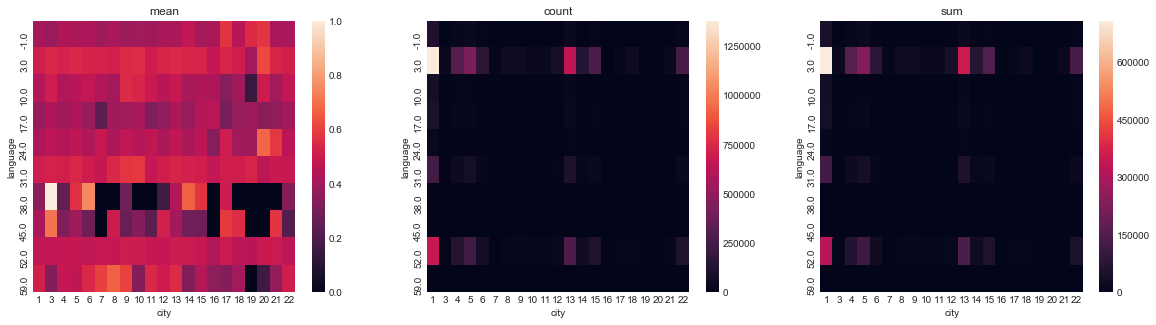

In [13]:
utils_nb.heatmap(data, 'language', 'city', annot=False)

## Age and Genres

In [ ]:
%%time
multi_catg_heatmap('genre_list', 'age')

## Popular Artist
-  We evaluate the popularity of the artist by calculate `mean * sum` by target label, value of target belong to [0, 1], so `sum` can represent the popularity but, maybe there are many 0 in the votes, so multiple the `mean` to get more fair result
-  According the boxplot, the popularity distribution is very skew, most of them close to zero, this is expected result, for this situation, we will add some features like the interaction between `[target + artist], [target + language]`..., etc.

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

<br/>
<br/>
<br/>
## Filter some rows

1. First we filter out the majority and the minority => [100 <= msno.group.size <= 1000], we don't want some majority to dominate the model
2. Insure that records of target = 1 greater than 35, we want 30% in valid data records of target = 1 greater than 10
    ```
    35 * 0.3 = 10.5
    ```

In [ ]:
""" Use DataFrameGroupBy.filter will be greate !!!"""
# msno_grp = data.groupby('msno')
# msno_grp.size().describe()

# df = pd.DataFrame({'size': msno_grp.size(), 'sum': msno_grp.target.sum()})

# data = data[data.msno.isin(df.query('sum >= 35 and 100 <= size and size <= 1000').index)]
# print(data.shape)
# print(data.target.value_counts())

In [ ]:
enc = utils.CounterEncoder()
enc.partial_fit( train.source_system_tab )

In [ ]:
np.linalg.norm([1, 2, 3] / np.linalg.norm([1, 2, 3]))


In [ ]:
feat = 'source_system_tab'
feat_dummies = pd.get_dummies(data[feat])
feat_dummies.columns = ['msno_%s_'%feat + '%s'%col for col in feat_dummies.columns]
feat_dummies.head()
feat_dummies['msno'] = data['msno'].values
feat_dummies = feat_dummies.groupby('msno').mean()
feat_dummies['msno'] = feat_dummies.index
a = members.merge(feat_dummies, on='msno', how='left')
a.head()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

encoded, origin, feat_data, target_, all_ = Ctrl.instance.inspect('promo2')

## Test

In [56]:
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

with tf.Graph().as_default():
    norm = tf.norm(tf.constant([1., 2., 3.]), ord='euclidean')
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        print( sess.run(norm) )

3.7416575
